# NEMA Photoelectric

- Photoelectric interaction in PETALO

In [1]:
import Pkg

In [2]:
Pkg.add.(["HTTP", "Plots", "DataFrames", "HDF5","DrWatson", "StatsBase", "PhysicalConstants"]);

In [3]:
Pkg.add.(["Test"]);

In [4]:
Pkg.add.(["VegaLite","VegaDatasets"]);

In [5]:
Pkg.add.(["LsqFit","GLM"])

2-element Vector{Nothing}:
 nothing
 nothing

In [6]:
using LsqFit
using GLM

In [7]:
using HTTP
using Plots
using VegaLite
using VegaDatasets
using DataFrames
using HDF5
using DrWatson
using Test
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [8]:
using Glob
using CSV

In [9]:
using Statistics
using StatsBase
using Printf

In [10]:
using Logging

In [11]:
@quickactivate "JPetalo"

In [12]:
pwd()

"/Users/jj/JuliaProjects/JPetalo/notebooks"

In [13]:
datadir()

"/Users/jj/JuliaProjects/JPetalo/data"

In [14]:
srcdir()

"/Users/jj/JuliaProjects/JPetalo/src"

In [367]:
include(srcdir("jpetalo.jl"))

Main.JPetalo

In [16]:
import Unitful:
    nm, μm, mm, cm, m, km, inch, ft, mi,
    ac,
    mg, g, kg,
    Ra, °F, °C, K,
    rad, °,
    ns, μs, ms, ps, s, minute, hr, d, yr, Hz,
    eV,
    μJ, mJ, J,
	mW, μW, W,
    A, N, mol, mmol, V, L, mL, μL, M

In [17]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

In [18]:
function grfq(q)
    return Float32(326.9 + 0.0226 * q)
end
rfq(q::Float32) = grfq(q)
rfq(q::Float64) = grfq(q)

rfq (generic function with 2 methods)

In [19]:
function grfq2(q)
    return Float32(297.85 + 0.031 * q)
end
rfq2(q::Float32) = grfq(q)
rfq2(q::Float64) = grfq(q)

rfq2 (generic function with 2 methods)

# Characterization of PETALO

In [366]:
loglevel("Info")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(42) open, 0 bytes waiting))), Debug, Dict{Any, Int64}())

### Read a summary data frame with photoelectric interactions

In [231]:
drx = datadir("nema3df")
input = string(drx,"/nemadf_f300_pde_1_sigmatof_1ps_q2_3000_12000_kmeans_phot.csv")
n3df = DataFrame(CSV.File(input));

In [174]:
println(names(n3df))

["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "rq1", "rq2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]


## Dependence of energy with radius of interaction
- Histograming the energy deposited in the SiPMs yields a wide and non gaussian distribution
- The reason is that the energy deposited in the SiPMs depends of the radius at which the gamms interacted.
- The relation is roughly linear in a good range of radius, cannot be used for charge too low and saturates for charge too high
- This dependence can be used to define an estimator, "rq" of the radius of interaction

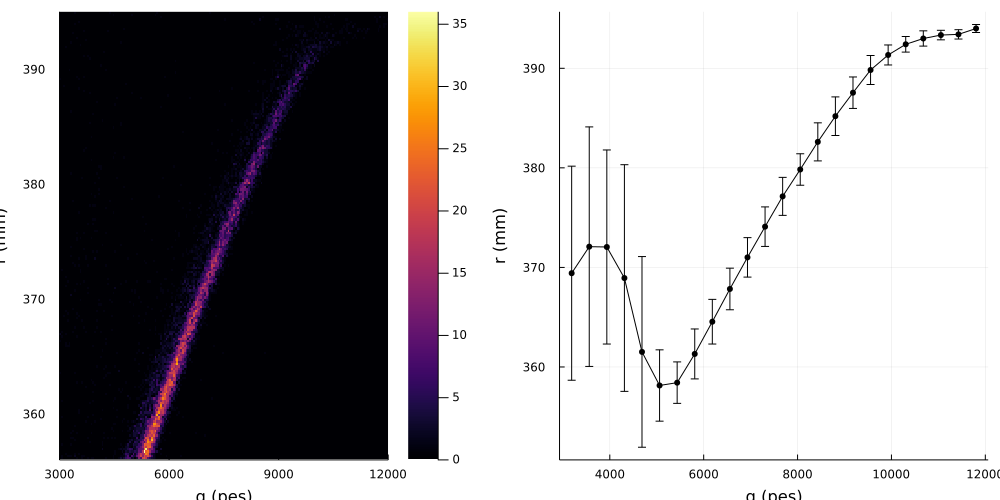

In [376]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.q1,n3df.r1, 250, "q (pes)", "r (mm)")
pqrdf = JPetalo.p1df(n3df.q1, n3df.r1, 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("q (pes)")
ylabel!("r (mm)")
plot(phqr, pp, legend=false, size = (1000, 500), fmt = :png)

### Below 5000 pes no reliable fit.

In [311]:
n3h1q0 = JPetalo.select_by_column_value_interval(n3df, "q1", 3000.0, 5200.0);

In [315]:
function fcqr(df; h=1, qmin=3000.0, qmax=5200.0, bin=5)
    function qr(h)
    if h==1
        return "q1", "r1"
    else
        return "q2", "r2"
    end
end
    qq, rr = qr(h)
    dfq   = JPetalo.select_by_column_value_interval(df, qq, qmin, qmax)
    pqrdf = JPetalo.p1df(dfq[!,qq], dfq[!,rr], bin)
    lfqr, pqr, cqr = JPetalo.lfit(pqrdf);
    return pqrdf, lfqr, pqr, cqr
end

fcqr (generic function with 5 methods)

In [317]:
pqrdf, lfqr, pqr, cqr = fcqr(n3df, h=1, qmin=3000.0, qmax=5200.0, bin=5);

┌ Info: cqr
│   cqr = [396.2541225546623, -0.007039170870831917]
└ @ Main In[319]:1


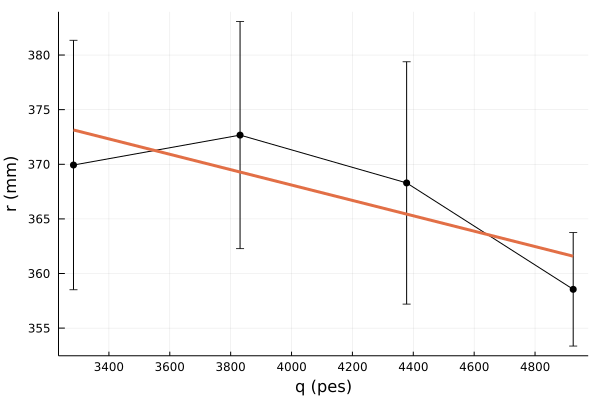

In [319]:
@info "cqr" cqr
pqr = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pqr = plot!(pqr,pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)")

## Fit in range (5200, 9000) 

### hemisphere 1

In [320]:
pqrdf, lfqr, pqr, cqr = fcqr(n3df, h=1, qmin=5200.0, qmax=9000.0, bin=25);

┌ Info: cqr
│   cqr = [314.95785270939047, 0.008044055549871408]
└ @ Main In[321]:1


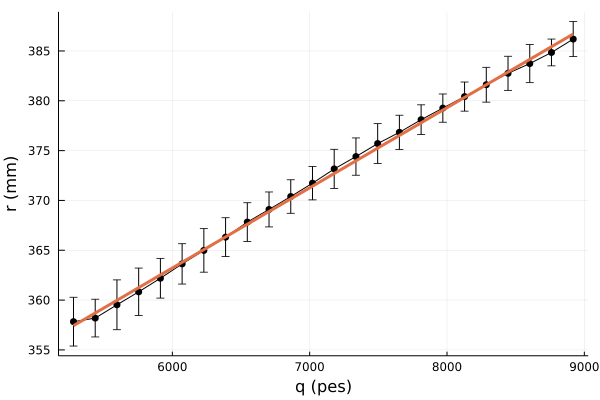

In [321]:
@info "cqr" cqr
pqr = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pqr = plot!(pqr,pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)")

### hemisphere 2

┌ Info: cqr
│   cqr = [315.5396548328888, 0.00801093308976291]
└ @ Main In[326]:2


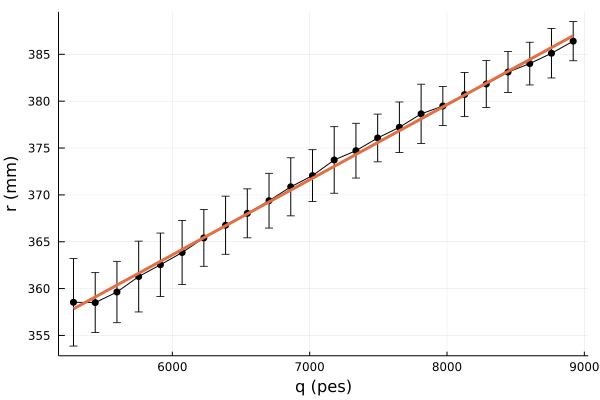

In [326]:
pqrdf, lfqr, pqr, cqr = fcqr(n3df, h=2, qmin=5200.0, qmax=9000.0, bin=25)
@info "cqr" cqr
pqr = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pqr = plot!(pqr,pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)")

## Fit in range (9,000, 10,000)

### hemisphere 1

In [322]:
pqrdf, lfqr, pqr, cqr = fcqr(n3df, h=1, qmin=9000.0, qmax=10000.0, bin=10);

┌ Info: cqr
│   cqr = [338.5791348977891, 0.00534901096252886]
└ @ Main In[323]:1


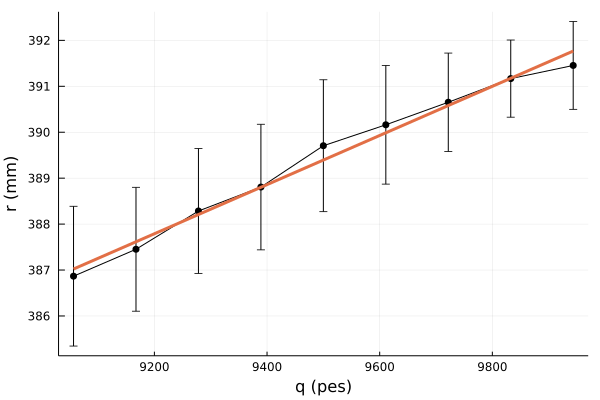

In [323]:
@info "cqr" cqr
pqr = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pqr = plot!(pqr,pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)")

### hemisphere 2

┌ Info: cqr
│   cqr = [340.6981664356943, 0.005162294547117465]
└ @ Main In[328]:2


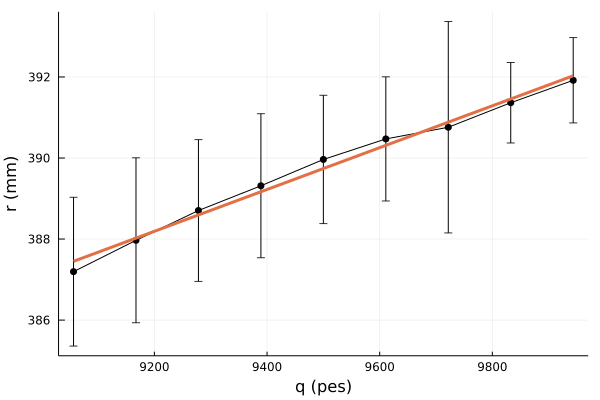

In [328]:
pqrdf, lfqr, pqr, cqr = fcqr(n3df, h=2, qmin=9000.0, qmax=10000.0, bin=10)
@info "cqr" cqr
pqr = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pqr = plot!(pqr,pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)")

## Fit in range 10k-12k

### hemisphere 1

In [324]:
pqrdf, lfqr, pqr, cqr = fcqr(n3df, h=1, qmin=10000.0, qmax=12000.0, bin=5);

┌ Info: cqr
│   cqr = [380.7640429872516, 0.0011283429162648561]
└ @ Main In[325]:1


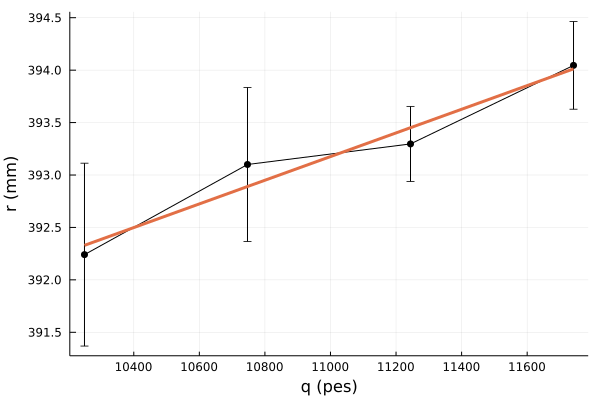

In [325]:
@info "cqr" cqr
pqr = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pqr = plot!(pqr,pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)")

### hemisphere 2

┌ Info: cqr
│   cqr = [382.3572061366169, 0.0009920749769955447]
└ @ Main In[329]:2


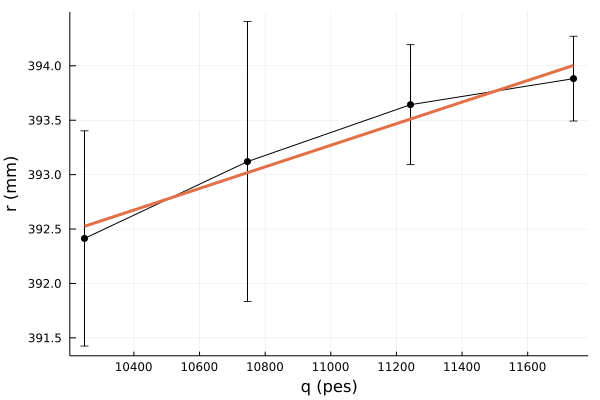

In [329]:
pqrdf, lfqr, pqr, cqr = fcqr(n3df, h=2, qmin=10000.0, qmax=12000.0, bin=5)
@info "cqr" cqr
pqr = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pqr = plot!(pqr,pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)")

## Fit function

In [355]:
function crfq(; q0::Float64=5200.0, q1::Float64=9000.0, q2::Float64=10000.0, q3::Float64=120000.0, 
              rmin::Float64=355.5, rmax::Float64=395.4)
    
    function rfq(q)
        if q < q0
            return rmin
        elseif q > q0 && q < q1
            return 315.0 + 0.008*q
        elseif q > q1 && q < q2
            return 339.0 + 0.005*q
        elseif q > q2 && q < q3
            return 381.0 + 0.001*q
        else
            return rmax
        end
    end
    
    return rfq
end


crfq (generic function with 8 methods)

In [356]:
rfqx = crfq(q0=5200.0, q1=9000.0, q2=10000.0, q3=120000.0, rmin=355.5, rmax=395.4)

(::var"#rfq#57"{Float64, Float64, Float64, Float64, Float64, Float64}) (generic function with 1 method)

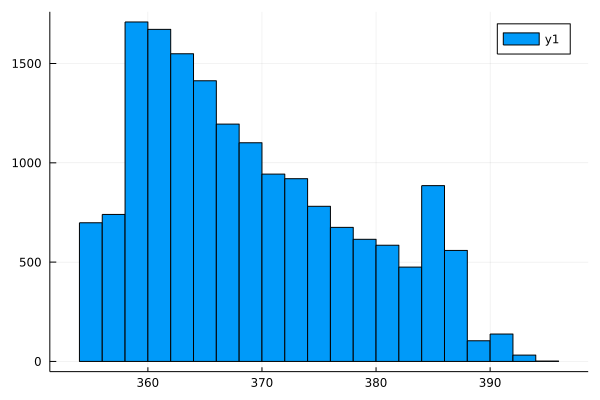

In [363]:
histogram(rfqx.(n3df.q1))

### Fitted R as a function of q

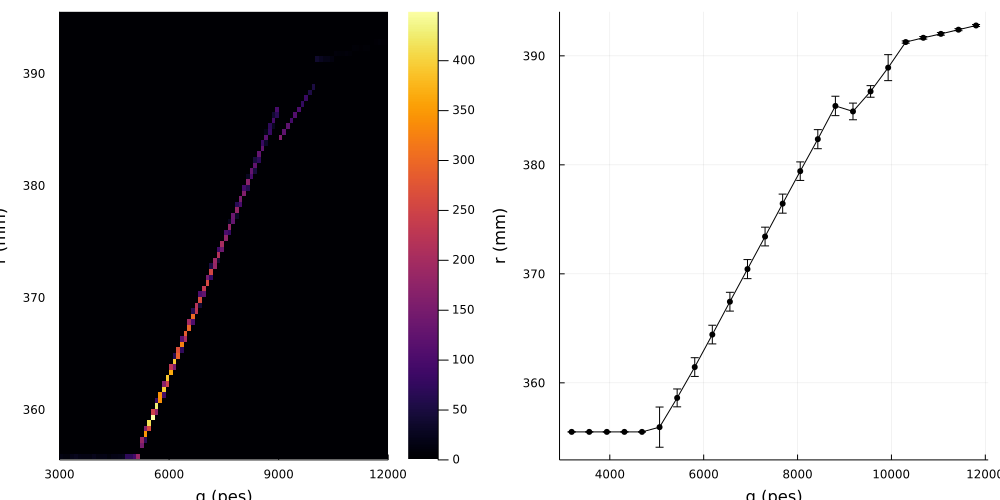

In [378]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.q1,rfqx.(n3df.q1), 150, "q (pes)", "r (mm)")
pqrdf = JPetalo.p1df(n3df.q1, rfqx.(n3df.q1), 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("q (pes)")
ylabel!("r (mm)")
plot(phqr, pp, legend=false, size = (1000, 500), fmt = :png)

## Fitted R as a function of R

### Using all range

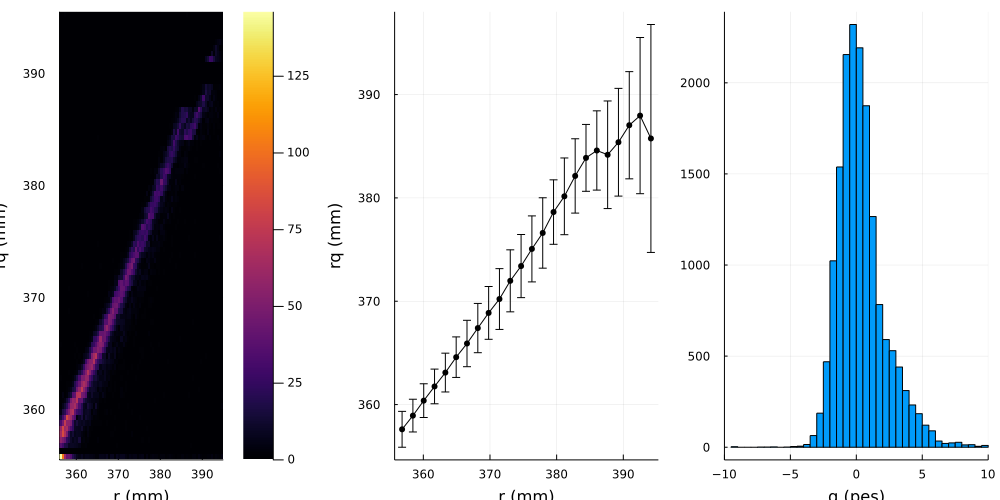

In [383]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3df.r1,rfqx.(n3df.q1), 150, "r (mm)", "rq (mm)")
pqrdf = JPetalo.p1df(n3df.r1, rfqx.(n3df.q1), 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("r (mm)")
ylabel!("rq (mm)")
hqc = JPetalo.hist1d(n3df.r1 - rfqx.(n3df.q1), 50, -10., 10.)
phqc = plot(hqc, xlim=(-10., 10.), xlabel="q (pes)");
plot(phqr, pp, phqc, layout = (1, 3), legend=false, size = (1000, 500), fmt = :png)

In [390]:
xmu, xstd = JPetalo.mean_std(n3df.r1 - rfqx.(n3df.q1), -4.0, 4.0)

(0.161244972712272, 1.435208307267861)

### Cutting at 385.5 

In [385]:
n3h1q   = JPetalo.select_by_column_value_interval(n3df, "q1", 5200., 12000.)
n3h1qr   = JPetalo.select_by_column_value_interval(n3df, "r1", 355.5, 385.5);

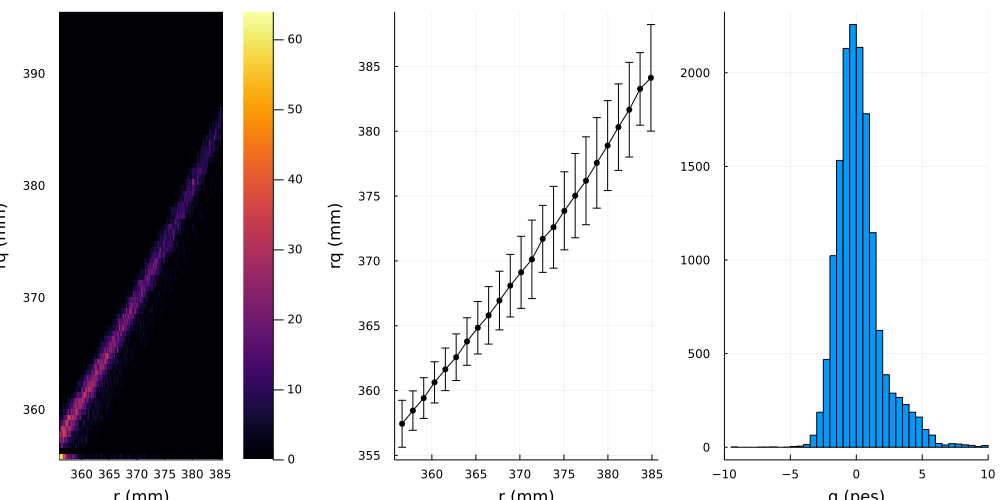

In [386]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3h1qr.r1,rfqx.(n3h1qr.q1), 150, "r (mm)", "rq (mm)")
pqrdf = JPetalo.p1df(n3h1qr.r1, rfqx.(n3h1qr.q1), 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("r (mm)")
ylabel!("rq (mm)")
hqc = JPetalo.hist1d(n3h1qr.r1 - rfqx.(n3h1qr.q1), 50, -10., 10.)
phqc = plot(hqc, xlim=(-10., 10.), xlabel="q (pes)");
plot(phqr, pp, phqc, layout = (1, 3), legend=false, size = (1000, 500), fmt = :png)

In [389]:
xmu, xstd = JPetalo.mean_std(n3h1qr.r1 - rfqx.(n3h1qr.q1), -4.0, 4.0)

(0.005079794977639106, 1.3444988763363208)

### Number of SiPMs with charge above threshold

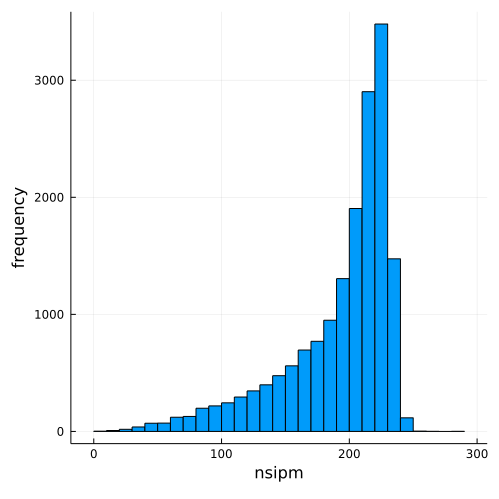

In [391]:
hnsipm, pnsipm = JPetalo.hist1d(n3df.nsipm1,  "nsipm", 50);
plot(pnsipm,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)

In [133]:
function gfit_gauss(x, xmin, xmax, bins=50)
    function gausx(x, μ, σ, N)
        return N * exp(-(x - μ)^2/(2*σ^2))
    end
    
    xmu, xstd = JPetalo.mean_std(x, xmin, xmax)
    @debug xmu xstd
    
    h = JPetalo.hist1d(x,  bins, xmin, xmax)
    edges = collect(h.edges[1])
    w = h.weights
    c =[0.5 *(edges[i] + edges[i+1]) for i in 1:length(edges)-1]
    @debug "histo" edges w c 

    @. gauss1(x, p) = p[1]* exp(-(x - xmu)^2/(2*xstd^2))
    p0 = [1.0]
    fq = curve_fit(gauss1, c, w, p0)    
    N =coef(fq)[1][1]
    @debug "gauss1" N
    
    @. gauss2(x, p) = p[1]* exp(-(x - p[2])^2/(2*p[3]^2))
    p0 = [N, xmu, xstd]
    fq = curve_fit(gauss2, c, w, p0)
    cfq = coef(fq)
    @debug "coef(fq)" cfq
    N =cfq[1]
    mu =cfq[2]
    std  =cfq[3]
    @debug "gauss2" N mu std
    
    return xmu, xstd, mu, std, N, c, gausx.(c, (mu,), (std,), (N),)    
end

gfit_gauss (generic function with 2 methods)

## zstd

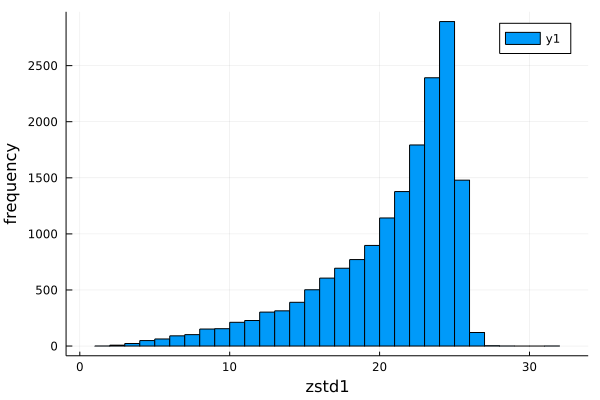

In [394]:
hzstd, pzstd = JPetalo.hist1d(n3df.zstd1, "zstd1", 50,  0., 35.)
plot(pzstd)

In [415]:
n3h1z = JPetalo.select_by_column_value_interval(n3df, "zstd1", 5.0, 25.0);

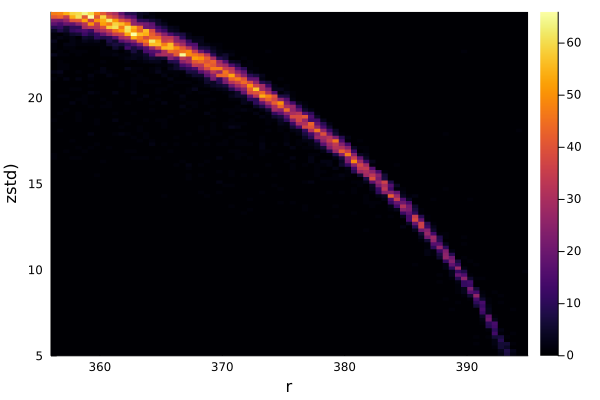

In [416]:
xe,ye,hrzstd,przstd = JPetalo.hist2d(n3h1z.r1, n3h1z.zstd1, 150, "r", "zstd)")
plot(przstd)

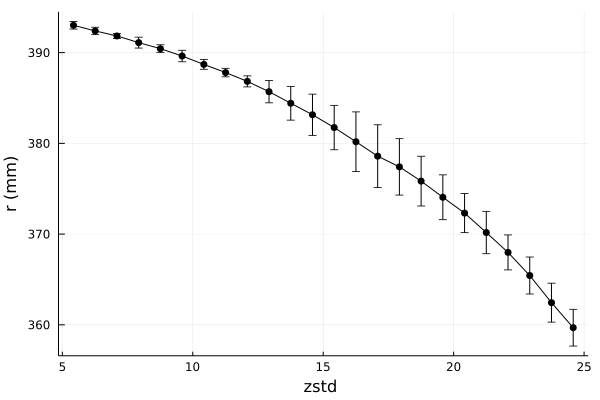

In [417]:
pqrdf = JPetalo.p1df(n3h1z.zstd1, n3h1z.r1 , 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("zstd ")
ylabel!("r (mm)")

In [418]:
@. pol(x, p) = p[1] + p[2] * x + p[3] * x^2 
p0 = [1.0, 1.0, 1.0]
fq = curve_fit(pol, pqrdf.x_mean, pqrdf.y_mean, p0)
cfq = coef(fq)
@info "coef(fq)" cfq
sfq = stderror(fq)
@info "std(fq)" sfq
@info "margin_of_error (90%)" margin_error(fq, 0.1)
@info " confidence_interval (90%)" confidence_interval(fq, 0.1)


┌ Info: coef(fq)
│   cfq = [392.901531156604, 0.30494998085604086, -0.06588514377910579]
└ @ Main In[418]:5
┌ Info: std(fq)
│   sfq = [0.5509486124655415, 0.08027582596870585, 0.002636483926473938]
└ @ Main In[418]:7
┌ Info: margin_of_error (90%)
│   margin_error(fq, 0.1) = [0.9480409147141322, 0.13813405780301202, 0.004536711004857622]
└ @ Main In[418]:8
┌ Info:  confidence_interval (90%)
│   confidence_interval(fq, 0.1) = [(391.9534902418899, 393.8495720713181), (0.16681592305302884, 0.4430840386590529), (-0.07042185478396341, -0.06134843277424817)]
└ @ Main In[418]:9


In [419]:
function grfzstd(p::Vector{Float64})
    function rfz(z)
        return p[1] + p[2] * z + p[3] * z^2
    end
    return rfz
end

grfzstd (generic function with 1 method)

In [420]:
rfzx = grfzstd(cfq)

(::var"#rfz#59"{Vector{Float64}}) (generic function with 1 method)

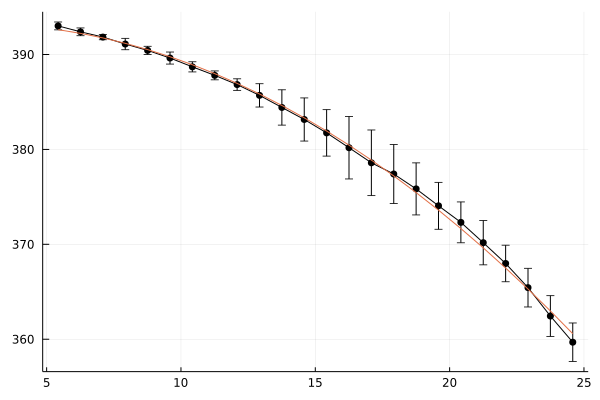

In [421]:
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
pp = plot!(pp, pqrdf.x_mean, rfzx.(pqrdf.x_mean))

## Fitted R from zstd as a function of R

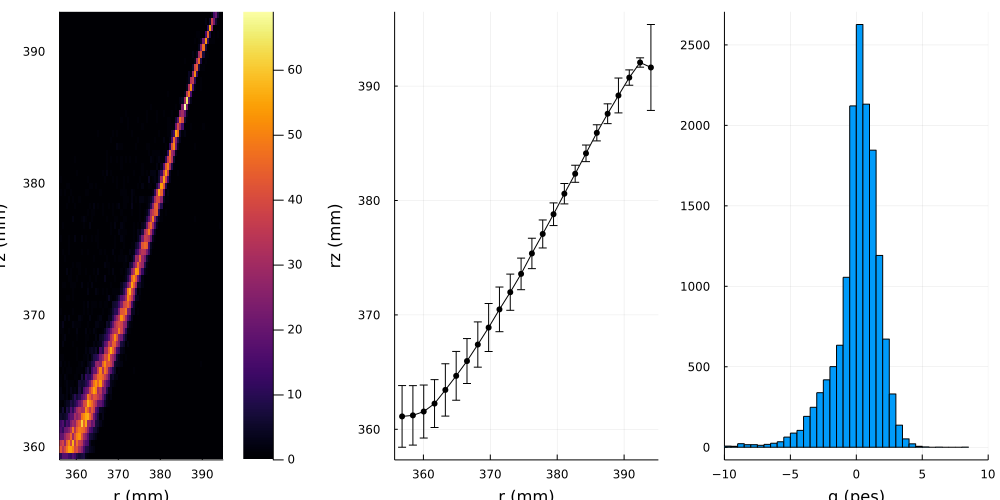

In [422]:
xe,ye,hqr,phqr = JPetalo.hist2d(n3h1z.r1,rfzx.(n3h1z.zstd1), 150, "r (mm)", "rz (mm)")
pqrdf = JPetalo.p1df(n3h1z.r1, rfzx.(n3h1z.zstd1), 25)
pp = plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
xlabel!("r (mm)")
ylabel!("rz (mm)")
hqc = JPetalo.hist1d(n3h1z.r1 - rfzx.(n3h1z.zstd1), 50, -10., 10.)
phqc = plot(hqc, xlim=(-10., 10.), xlabel="q (pes)");
plot(phqr, pp, phqc, layout = (1, 3), legend=false, size = (1000, 500), fmt = :png)

In [423]:
xmu, xstd = JPetalo.mean_std(n3h1z.r1 - rfzx.(n3h1z.zstd1), -4.0, 4.0)

(0.22831759274278943, 1.39809746304995)

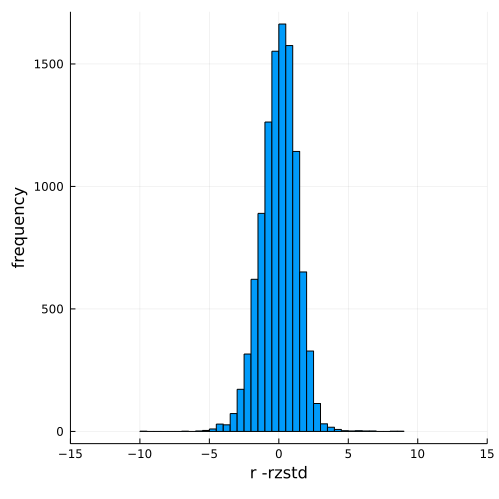

In [113]:
h, p = JPetalo.hist1d(n3dfqrz.r1 - rfzstd.(n3dfqrz.zstd1),  "r -rzstd", 50, -10.0, 10.0)
plot(p,  layout = (1, 1), xlim=(-15,15), size = (500, 500), 
     legend=false, fmt = :png)

In [127]:
loglevel("Debug")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

In [135]:
xmu, xstd, mu, std, NN, xg, yg = gfit_gauss(n3dfqrz.r1 - rfzstd.(n3dfqrz.zstd1), -5.0, 5.0)

┌ Debug: 0.017848917781003174
│   xstd = 1.2662194965370446
└ @ Main In[133]:7
┌ Debug: histo
│   edges = [-5.0, -4.8, -4.6, -4.4, -4.2, -4.0, -3.8, -3.6, -3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0]
│   w = [2, 4, 6, 17, 11, 7, 12, 18, 32, 31, 57, 72, 97, 117, 145, 233, 231, 324, 336, 387, 455, 519, 568, 640, 633, 654, 698, 634, 654, 598, 549, 425, 329, 274, 217, 151, 120, 89, 56, 26, 19, 10, 5, 6, 8, 4, 2, 3, 0, 2]
│   c = [-4.9, -4.699999999999999, -4.5, -4.300000000000001, -4.1, -3.9, -3.7, -3.5, -3.3, -3.1, -2.9, -2.7, -2.5, -2.3, -2.1, -1.9, -1.7000000000000002, -1.5, -1.2999999999999998, -1.1, -0.9, -0.7, -0.5, -0.30000000000000004, -0.1, 0.1, 0.30000000000000004, 0.5, 0.7, 0.9, 1.1, 1.2999999999999998, 1.5, 1.7000000000000002, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.300000

(0.017848917781003174, 1.2662194965370446, 0.1157955934551933, 1.230334837490145, 675.6772781261276, [-4.9, -4.699999999999999, -4.5, -4.300000000000001, -4.1, -3.9, -3.7, -3.5, -3.3, -3.1  …  3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.300000000000001, 4.5, 4.699999999999999, 4.9], [0.1662400176166605, 0.3182794155470128, 0.5934789770092584, 1.0777696229079565, 1.9062082726966936, 3.283511737307148, 5.5084651731439225, 9.000081760138672, 14.321421055953762, 22.194715571180453  …  35.66381895945257, 23.727571798800483, 15.374555118314666, 9.702320823163308, 5.963105821798606, 3.56938351499573, 2.0808353753874673, 1.1814246916144335, 0.6532782150669608, 0.35181481235607315])

In [136]:
@info "fit" xmu xstd mu std NN

┌ Info: fit
│   xmu = 0.017848917781003174
│   xstd = 1.2662194965370446
│   mu = 0.1157955934551933
│   std = 1.230334837490145
│   NN = 675.6772781261276
└ @ Main In[136]:1


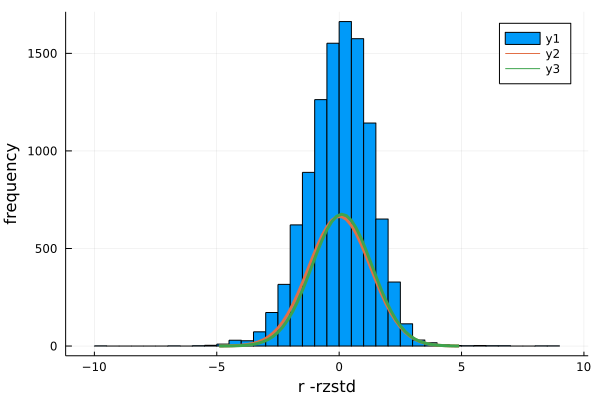

In [137]:
pfit = plot!(p, xg, yg, lw=3)

In [138]:
@info "mean = $mux std =$stdx"

┌ Info: mean = 0.017848917781003174 std =1.2662194965370446
└ @ Main In[138]:1


In [644]:
h, p = JPetalo.hist1d(n3dfqr.r - rfq.(n3dfqr.q),  "r -rrq", 50, -10.0, 10.0);

In [140]:
mux, stdx, mu, std, NN, xg, yg = gfit_gauss(n3dfqr.r1 - rfq.(n3dfqr.q1), -5.0, 5.0);

┌ Debug: -0.5180234421147575
│   xstd = 2.122502560591989
└ @ Main In[133]:7
┌ Debug: histo
│   edges = [-5.0, -4.8, -4.6, -4.4, -4.2, -4.0, -3.8, -3.6, -3.4, -3.2, -3.0, -2.8, -2.6, -2.4, -2.2, -2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0]
│   w = [62, 68, 85, 103, 113, 128, 168, 187, 173, 199, 242, 250, 249, 297, 296, 341, 328, 298, 303, 351, 345, 337, 337, 363, 316, 313, 343, 305, 283, 287, 268, 231, 226, 223, 183, 191, 150, 137, 131, 108, 94, 84, 93, 65, 51, 52, 35, 35, 37, 31]
│   c = [-4.9, -4.699999999999999, -4.5, -4.300000000000001, -4.1, -3.9, -3.7, -3.5, -3.3, -3.1, -2.9, -2.7, -2.5, -2.3, -2.1, -1.9, -1.7000000000000002, -1.5, -1.2999999999999998, -1.1, -0.9, -0.7, -0.5, -0.30000000000000004, -0.1, 0.1, 0.30000000000000004, 0.5, 0.7, 0.9, 1.1, 1.2999999999999998, 1.5, 1.7000000000000002, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5, 

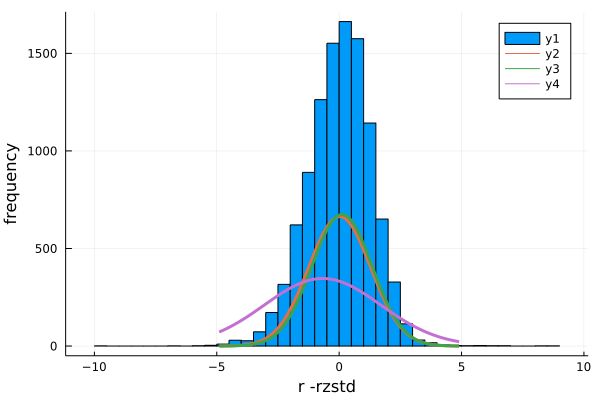

In [141]:
pfit = plot!(p, xg, yg, lw=3)

In [647]:
@info "mean = $mux std =$stdx"

┌ Info: mean = -0.7626392112857455 std =2.1634471708360286
└ @ Main In[647]:1


In [157]:
n3dfx = JPetalo.select_by_column_value(n3dfqr, "xs", 0.0);
n3dfxy = JPetalo.select_by_column_value(n3dfx, "ys", 10.0);
n3dfxyz = JPetalo.select_by_column_value(n3dfxy, "zs", 0.0);

### Resolution in (x,y,z,r)

In [165]:
hxtxr, pxtxr = JPetalo.hist1d(n3dfqr.xt1 - n3dfqr.x1, "xt - xr", 50,  -10., 10.);
plot(pxtxr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [166]:
hytyr, pytyr = JPetalo.hist1d(n3dfxyz.yt1 - n3dfxyz.y1, "yt - yr", 50,  -10., 10.);
plot(pytyr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [167]:
hztzr, pztzr = JPetalo.hist1d(n3dfxyz.zt1 - n3dfxyz.z1, "zt - zr", 50,  -10., 10.);
plot(pztzr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

In [168]:
hrtr, przr = JPetalo.hist1d(n3dfxyz.r1 - n3dfxyz.rq1, "r - rq", 50,  -10., 10.);
plot(przr,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png);

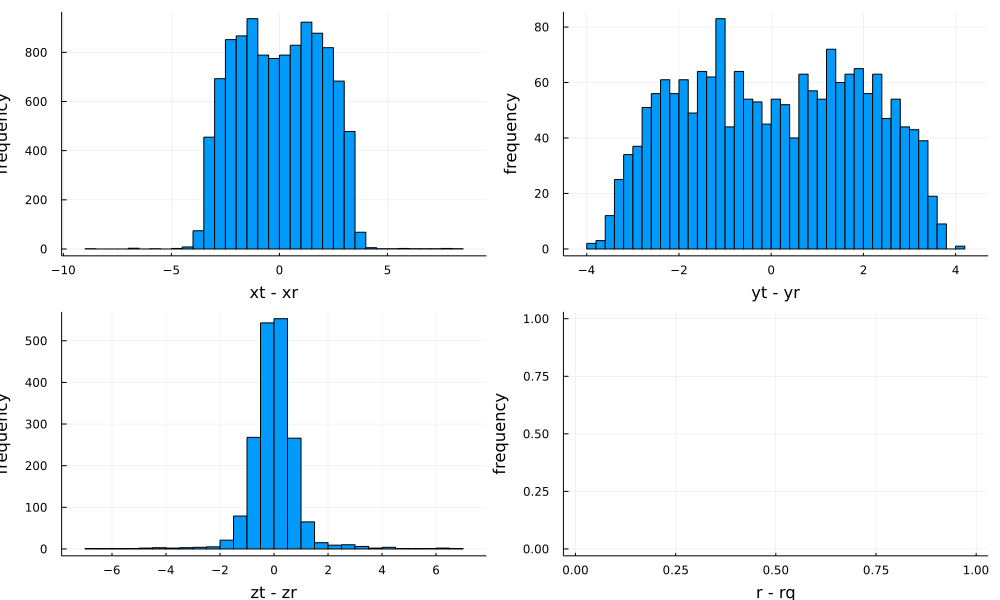

In [169]:
plot(pxtxr, pytyr,pztzr, przr, layout = (2, 2), size = (1000, 600), 
     legend=false, fmt = :png)

In [172]:
xmu, xstd = JPetalo.mean_std(n3dfqr.xt1 - n3dfqr.x1, -3.5, 3.5)
@printf "Resolution in x (mm) = %5.1f" xstd

Resolution in x (mm) =   1.9

In [874]:
xmu, xstd = JPetalo.mean_std(n3df.yt1 - n3df.yr1, -2.5, 2.5)
@printf "Resolution in y (mm) = %5.1f" xstd

Resolution in y (mm) =   1.2

In [875]:
xmu, xstd = JPetalo.mean_std(n3df.zt1 - n3df.zr1, -2.5, 2.5)
@printf "Resolution in y (mm) = %5.1f" xstd

Resolution in y (mm) =   0.8

In [876]:
xmu, xstd = JPetalo.mean_std(n3df.r1 - n3df.rq1, -5.0, 5.0)
@printf "Resolution in y (mm) = %5.1f" xstd

Resolution in y (mm) =   2.1

In [878]:
@info names(n3df)

┌ Info: ["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "rq1", "rq2", "t1", "t2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]
└ @ Main In[878]:1


In [879]:
n3dfx = JPetalo.select_by_column_value(n3df, "xs", 0.0);

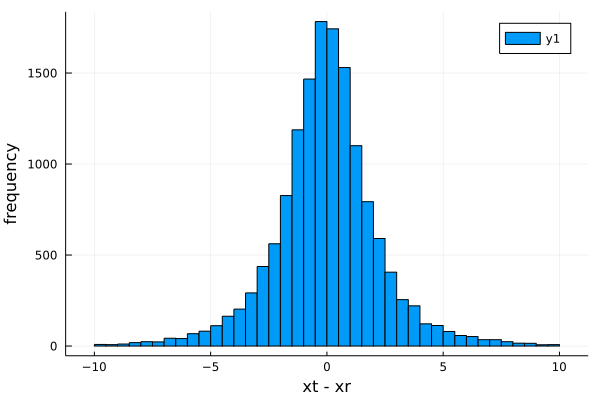

In [880]:
hxtxr, pxtxr = JPetalo.hist1d(n3dfx.xt1 - n3dfx.xr1, "xt - xr", 50,  -10., 10.)
plot(pxtxr)

In [881]:
n3dfxy = JPetalo.select_by_column_value(n3dfx, "ys", 10.0);

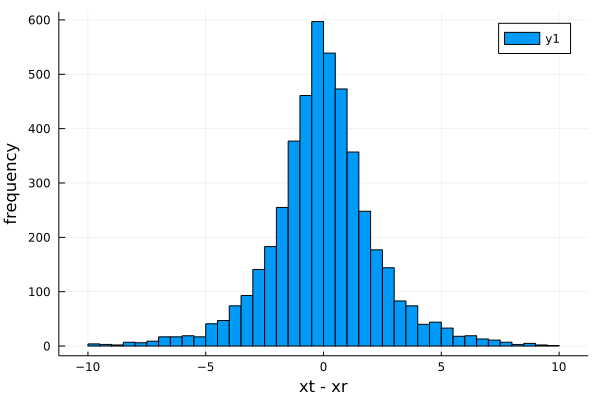

In [882]:
hxtxr, pxtxr = JPetalo.hist1d(n3dfxy.xt1 - n3dfxy.xr1, "xt - xr", 50,  -10., 10.)
plot(pxtxr)

In [883]:
n3dfxyz = JPetalo.select_by_column_value(n3dfxy, "zs", 0.0);

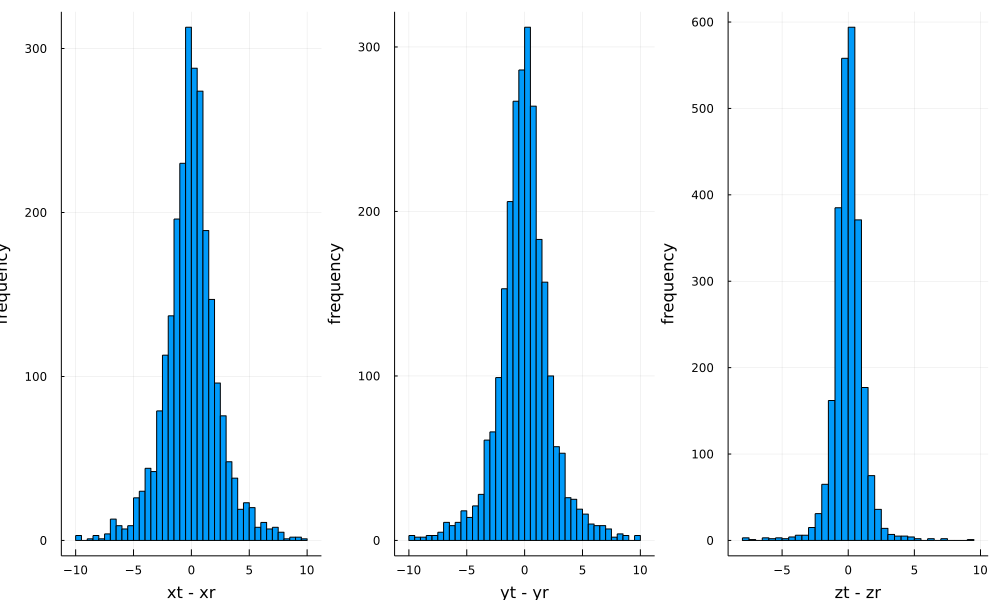

In [884]:
hx, px = JPetalo.hist1d(n3dfxyz.xt1 - n3dfxyz.xr1, "xt - xr", 50,  -10., 10.)
hy, py = JPetalo.hist1d(n3dfxyz.yt1 - n3dfxyz.yr1, "yt - yr", 50,  -10., 10.)
hz, pz = JPetalo.hist1d(n3dfxyz.zt1 - n3dfxyz.zr1, "zt - zr", 50,  -10., 10.)
plot(px, py, pz, layout = (1, 3), size = (1000, 600), legend=false, fmt = :png)

In [885]:
xmu, xstd = JPetalo.mean_std(n3dfxyz.xt1 - n3dfxyz.xr1, -5., 5.)
@printf "Resolution in x (mm) = %5.1f" xstd

Resolution in x (mm) =   1.8

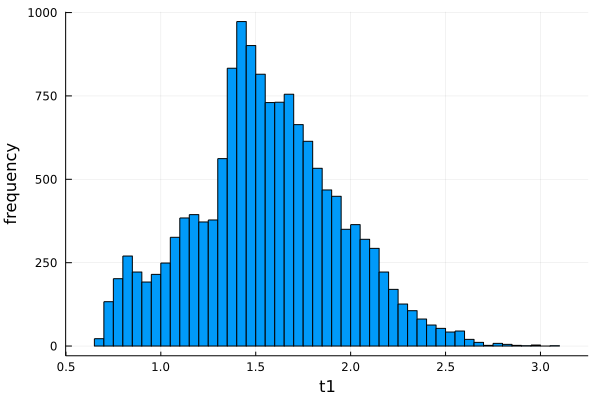

In [886]:
ht1, pt1 = JPetalo.hist1d(n3df.t1, "t1", 50,  -100., 100.)
plot(pt1, legend=false)

In [923]:
function ct12(df; reco=true)
    if reco
        return 1000.0*(df.tr1 - df.tr2)
    else
        return 1000.0 * (df.t1 - df.t2)
    end
end
        


ct12 (generic function with 1 method)

In [908]:
t12 = 1000.0 * (n3dfxyz.t1 - n3dfxyz.t2);

In [914]:
t12 = 1000.0*(n3dfxyz.tr1 - n3dfxyz.tr2);

In [975]:
t12 = ct12(n3dfxyz, reco=true);

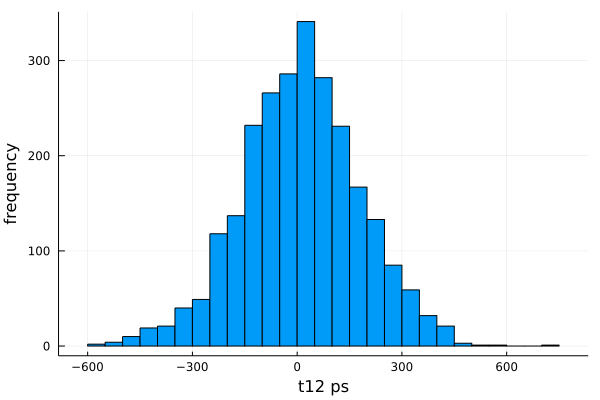

In [976]:
ht1t2, pt1t2 = JPetalo.hist1d(t12, "t12 ps", 50,  -2000., 2000.)
plot(pt1t2, legend=false)

In [977]:
xmu, xstd = JPetalo.mean_std(t12*1000.0, -300.0, 300.0)

(39.999999999965986, 178.54212388119933)

In [917]:
c0 =uconvert(mm/ns, float(SpeedOfLightInVacuum))

299.792458 mm ns⁻¹

In [918]:
cc = convert(Float32, c0/(mm*ns^-1))

299.79245f0

In [955]:
function ctsr(df; reco=true)
    if reco
        tsr1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        
    else
        tsr1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
        tsr2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xs[i], df.ys[i], df.zs[i]]) for i in 1:nrow(df)]/cc
    end
    return 1000.0*(tsr2 - tsr1)
end

ctsr (generic function with 1 method)

In [978]:
tsr12 = ctsr(n3dfxyz, reco=true);

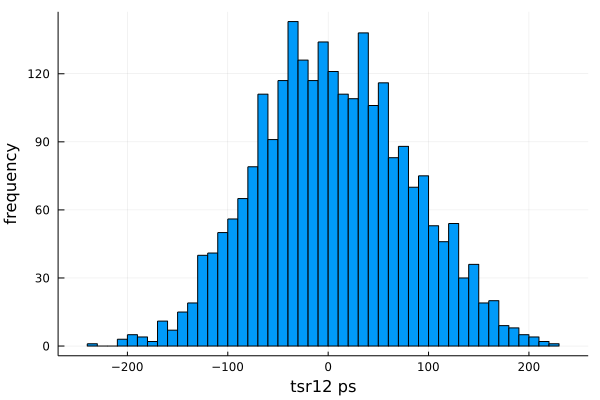

In [979]:
htsr12, psr1t2 = JPetalo.hist1d(tsr12, "tsr12 ps", 50,  -500., 500.)
plot(psr1t2, legend=false) 

In [980]:
xmu, xstd = JPetalo.mean_std(tsr12, -200.0, 200.0)

(5.368266881255396, 73.75147926170891)

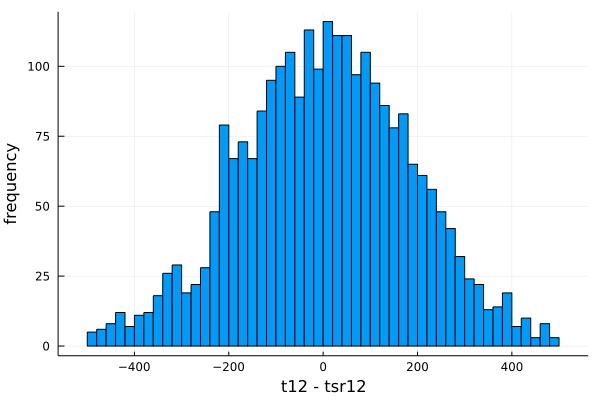

In [981]:
h12, p12 = JPetalo.hist1d(t12-tsr12, "t12 - tsr12", 50,  -500., 500.)
plot!(p12, legend=false) 

In [982]:
xmu, xstd = JPetalo.mean_std(t12-tsr12, -400.0, 400.0)

(6.551269063335126, 166.98125972317314)

In [964]:
function crb(df; reco=true)
    if reco
        trb1 = [JPetalo.dxyz([df.xr1[i], df.yr1[i], df.zr1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/cc;
        trb2 = [JPetalo.dxyz([df.xr2[i], df.yr2[i], df.zr2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/cc;
        
    else
        trb1 = [JPetalo.dxyz([df.x1[i], df.y1[i], df.z1[i]], 
                             [df.xb1[i], df.yb1[i], df.zb1[i]]) for i in 1:nrow(df)]/cc;
        trb2 = [JPetalo.dxyz([df.x2[i], df.y2[i], df.z2[i]], 
                             [df.xb2[i], df.yb2[i], df.zb2[i]]) for i in 1:nrow(df)]/cc;
     end
    return 1000.0*(trb2 - trb1)
end

crb (generic function with 1 method)

In [983]:
trb12 = ctsr(n3dfxyz, reco=true);

In [935]:
trb1 = [JPetalo.dxyz([n3dfxyz.xr1[i], n3dfxyz.yr1[i], n3dfxyz.zr1[i]], [n3dfxyz.xb1[i], n3dfxyz.yb1[i], n3dfxyz.zb1[i]]) for i in 1:nrow(n3dfxyz)]/cc;

In [936]:
trb2 = [JPetalo.dxyz([n3dfxyz.xr2[i], n3dfxyz.yr2[i], n3dfxyz.zr2[i]], [n3dfxyz.xb2[i], n3dfxyz.yb2[i], n3dfxyz.zb2[i]]) for i in 1:nrow(n3dfxyz)]/cc;

In [937]:
trb12 = 1000.0*(trb2 - trb1);

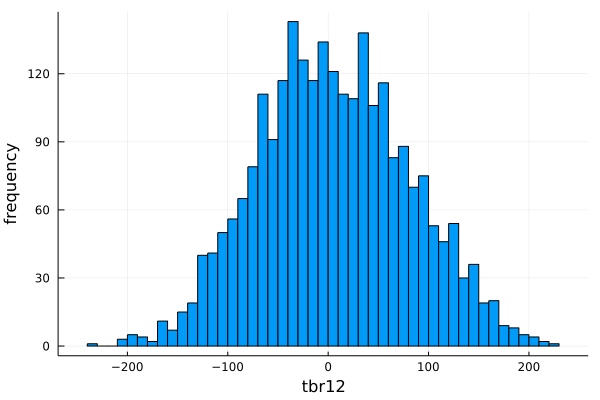

In [984]:
htrb12, ptrb12 = JPetalo.hist1d(trb12, "tbr12", 50,  -500., 500.)
plot(ptrb12, legend=false) 

In [985]:
xmu, xstd = JPetalo.mean_std(trb12, -200.0, 200.0)

(5.368266881255396, 73.75147926170891)

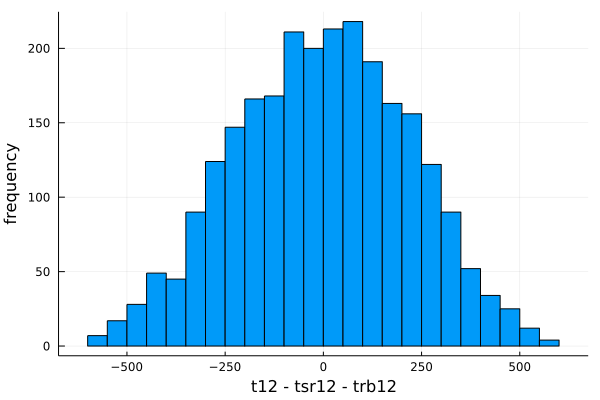

In [989]:
h12, p12 = JPetalo.hist1d(t12-tsr12 - trb12, "t12 - tsr12 - trb12", 50,  -600., 600.)
plot!(p12, legend=false) 

In [990]:
xmu, xstd = JPetalo.mean_std(trb12, -500.0, 500.0)

(5.591267323816779, 74.88261434163077)